# **Process**
**Step1：Read and analyze data**

1.1.   Read cat's eyes data and classify with its polorization: 1-2stars as negative，4-5stars as positive，remove 3 stars review. (pandas)

1.2.   Because our reviews have 200k+ which is really big, and within the reviews, there are more posotive reveiws than negative reviews. So we use randomization to balance the amount of reviews. And we only keep the useful information like the stars and reviews. (pandas, sklearn)

**step2: Data preprocessing**

2.1.   Using NLP to clean the reviews by removing the stopwords and punctuations， here we use Harbin Institute of Technolodgy's stopwords. Using NLP segmentation to convert text to essential words, and here we use Chinese segmentation tool called Jieba. 

>a. Remove the punctuations

>b. Use Jieba to segment the text 

>c. Remove the phrases if they displayed in the stopwords list

2.2 Using two tokenization tool to vectorize the keywords. Our goal is to find out which method can use the least tokens to represnt the most comments.

>a. Use tensorflow.keras tokenizer to tokenize the dataset 

>b. Use Chinese Word Vector to tokenize the keywords. Here we use gensim. 

2.3 Convert to one-hot encoding format， 

**step3: Modeling**

3.1 We use 3 models, they are 

>a. Fully-connected network 

>b. RNN

>c. CNN

and we use word embeddings to improve the accuracy 

3.2 Compare and contrast RNN, CNN, multiwindow and two vectorization methods. 



# I. read data and check data

In [ ]:
#_*_coding=utf-8_*_
from plotnine import *
import pandas as pd
import numpy as np
%matplotlib inline
import os,re,time,random,matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import jieba #分词
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Read data
from google.colab import drive
drive.mount('/content/gdrive')
#os.listdir()

data=pd.read_csv('gdrive/MyDrive/ColabNotebooks/DMSC.csv', index_col=0)
# dataset looks like this, it contains 9 column, we are interested in Commnet and Star
data.info()
data.groupby("Star").size().plot(kind="bar")


KeyboardInterrupt: ignored

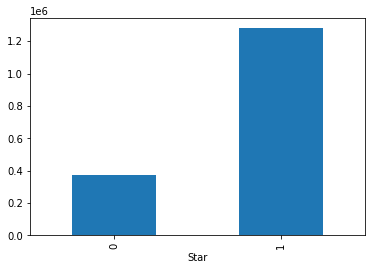

In [ ]:
#1-2 negative 4-5 positive
data=data.drop(data[data['Star']==3].index)
data['Star']=data['Star'].map({1:0,2:0,4:1,5:1})
#distribution of sentiment type,note that they are not balanced, we will deal with this later
data.groupby("Star").size().plot(kind="bar")

In [ ]:
#Since the rating distribution is not balanced, we balance the positive and negative sentments by sampling
# Sample_batch is used to control the sample size, here we use a small set to reduce computation time
sample_batch=200
sample_df = data.groupby(['Movie_Name_CN', 'Star']).apply(lambda x: x.sample(n=int(2125056/(28*sample_batch)), replace=True, random_state=12))


In [ ]:
#define function to clean the sentences
#compared with english, chinese words are concatenated, therefore much difficult to indentify the words
def clean_str(line):
    line.strip('\n')
    line = re.sub(r"[^0-9^A-Z^a-z^\u4e00-\u9fff]", " ", line)
    line = re.sub(
        "[\-\s+\.\!\/_,$%^*\(\)\+(+\"\')]+|[+——！，。？、~@#￥%……&*（）<>\[\]:：★◆【】《》;；=?？]+", " ", line)
    return line.strip()

with open('gdrive/MyDrive/ColabNotebooks/stopwords.txt',encoding='utf-8') as f:
    stopwords = [line.strip('\n') for line in f.readlines()]
def cut(data, labels, stopwords):
    result = []
    new_labels = []
    for index in tqdm_notebook(range(len(data))):
        #1. Clean illegal chars in text
        comment = clean_str(data[index])
        label = labels[index]
        #2. jieba word cutting
        # dict and key words
        my_dict = os.getcwd() + r'\\userdict.txt'
        jieba.load_userdict(codecs.open('userdict.txt', 'r', encoding='utf-8'))
        # read key words 
        key_word_fn = 'keyword_list.txt'
        kw_list = keywords(key_word_fn)
               
        #write a function to replace original cut 
        seg_list = seg_sentence(comment, kw_list)
        #seg_list = jieba.cut(comment)
        
        #3. use stopwords to filter out unusable words
        seg_list = [x.strip('\n') for x in seg_list if x not in stopwords and len(x) > 1]
        
        if len(seg_list) > 1:
            result.append(seg_list)
            new_labels.append(label)
    # Return word cutting tuple and label tuple
    return result, new_labels

#replacing function
def seg_sentence(sentence, keyword_dict):
   outstr=[]
    stpword_fn = os.getcwd() + r'\stopwords.txt'
    sentence_seged = jieba.cut(sentence.strip())
    stopwords = stopwordslist(stpword_fn)  # load stopwords path 
    outstr = ""
    for word in sentence_seged:
        if word not in stopwords and word in keyword_dict.keys():
            if word != '\t':
                outstr.append(word)
                # outstr += " "
    return outstr


## used trained 
def token_w2v(data, labels):
  result = []
  new_labels = []
  for index in tqdm_notebook(range(len(data))):
      #1. Clean illegal chars in text
      comment = clean_str(data[index])
      label = labels[index]
      #2. jieba word cutting
      #
        seg = seg_sentence(comment, kw_list)
      #seg = jieba.cut(comment)
      seg_list = [x for x in seg]
      #2.1. use stopwords to filter out unusable words
      #seg_list = [x.strip('\n') for x in seg_list if x not in stopwords and len(x) > 1]
      #3. use cn_model 
      for i,word in enumerate(seg_list):
          
          try:
              # Turn word into cn_model index
              seg_list[i] =cn_model.vocab[word].index
              pass
          except KeyError:
              # if word not in dict, output with 0
              seg_list[i] = 0
              pass   
          pass
      result.append(seg_list)
      new_labels.append(label)
  pass  
  return result, new_labels

def reverse_tokens(tokens):
    text = ''
    for index in tokens:
        if index != 0:
            text = text + cn_model.index2word[index]
        else:
            text = text + ''
        pass
    return text
    pass

16979 4245 16979 4245


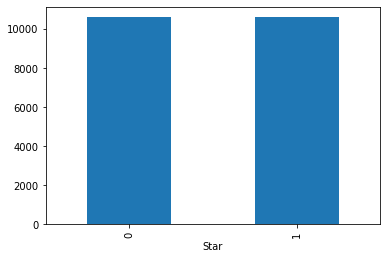

In [ ]:
#train vs test = 8:2
from sklearn.model_selection import train_test_split

comments = sample_df.values[:, 7]
star = sample_df.values[:, 6]
# split train dataset and test dataset
x_train_raw, x_test_raw, y_train_raw, y_test_raw, = train_test_split( comments, star, test_size=0.2, random_state=0)
print(len(y_train_raw), len(y_test_raw), len(x_train_raw), len(x_test_raw))
#distribution of sentiment type, more or less balanced
sample_df['Star'].groupby("Star").size().plot(kind="bar") 

# II Dataset Prepocessing

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.069 seconds.
Prefix dict has been built successfully.



localized vectorization: max words :24
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).



Chinese Word Vector vectorization: max words :66


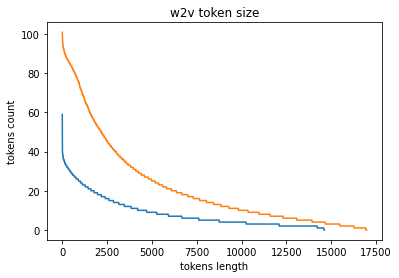

In [ ]:
# II.i  - create tokenizer using local data
from tensorflow.keras.preprocessing.text import Tokenizer
# clean train and test dataset
x_train_cut, y_train_cut = cut(x_train_raw, y_train_raw, stopwords)
x_test_cut, y_test_cut = cut(x_test_raw, y_test_raw, stopwords)
top_words = 10000
train_data = [' '.join(x) for x in x_train_cut]
token = Tokenizer(num_words=top_words)
token.fit_on_texts(train_data)

# vectorization
x_train_vec = token.texts_to_sequences(x_train_cut)
x_test_vec = token.texts_to_sequences(x_test_cut )

#Normalize the tokens' length, in order to save computing time
num_tokens = [ len(tokens) for tokens in x_train_vec ]
num_tokens.sort(reverse=True)
plt.plot(num_tokens)
plt.title('localized token size')
plt.ylabel('tokens count')
plt.xlabel('tokens length')

num_tokens = np.array(num_tokens)
# if token follows normal distribution, ave+2*sigma should cover 97.5% samples
max_words_vec = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_words_vec = int(max_words_vec)
print('localized vectorization: max words :'+ str(max_words_vec))

# II.ii - use Chinese_word_vector
import gensim
from gensim.models import KeyedVectors
drive.mount('/content/gdrive')
cn_model = KeyedVectors.load_word2vec_format('gdrive/MyDrive/ColabNotebooks/sgns.zhihu.bigram',binary=False, unicode_errors='ignore')
x_train_w2v, y_train_w2v = token_w2v(x_train_raw, y_train_raw)
x_test_w2v, y_test_w2v = token_w2v(x_test_raw, y_test_raw)

#Normalize the tokens' length, in order to save computing time
num_tokens = [ len(tokens) for tokens in x_train_w2v ]
num_tokens.sort(reverse=True)
plt.plot(num_tokens)
plt.title('w2v token size')
plt.ylabel('tokens count')
plt.xlabel('tokens length')

num_tokens = np.array(num_tokens)
# if token follows normal distribution, ave+2*sigma should cover 97.5% samples
max_words_w2v = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_words_w2v = int(max_words_w2v)
print('Chinese Word Vector vectorization: max words :'+ str(max_words_w2v))

# III. Build Model

In [ ]:
#build model
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import *
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import *


# allow us to select vectorized data
def vec_select(flag):
    if flag==1:
      X_train=x_train_vec
      Y_train=y_train_cut
      X_test=x_test_vec
      Y_test=y_test_cut
      max_words=max_words_vec
      return X_train,Y_train,X_test,Y_test,max_words
    elif flag==2:
      X_train=x_train_w2v
      Y_train=y_train_w2v
      X_test=x_test_w2v
      Y_test=y_test_w2v
      max_words=max_words_w2v
      return X_train,Y_train,X_test,Y_test,max_words
    else:
      print('Choose 1 or 2')

# In this section let's define some model 
def my_model(m_type,arg1,arg2,arg3,arg4,embedding_matrix,epochs,batch_size,mode):
  
 # plain vanilla model This model ~ blind guess
  if m_type=='Stupid':
    model = Sequential()
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
# embedding+RNN in general comusume significant time with CPU calculation
# consider use GPU to improve computing power, then in crease dataset size, and adopt deeper/wider RNN to improve accuracy
  elif m_type=='RNN':
    embedding_dims=arg1
    model = Sequential()
    if embedding_matrix=="":
      model.add(Embedding(top_words,embedding_dims,input_length=max_words))
    else:
     model.add(Embedding(top_words,embedding_dims, weights=[embedding_matrix],input_length=max_words,trainable=False))
    model.add(Bidirectional(LSTM(units=arg2, return_sequences=True)))
    model.add(LSTM(units=arg3, return_sequences=False))
    model.add(Dense(arg4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

# 2 Embedding + tri-gram
# CNN's results is inferor than RNN, however, because of the saving in computing power, in our case we can use a more complex model with bigger dataset to train the model.
# with CNN we can manipulate the model more easily
# in our case the embedding matrix is initialized randomly. in next steps we can consider using a pre-trained embedding model to improve the accuracy
#3 embedding + multi-windows
# combine multiple-Gram , a preferred way is use keras API to construct the model
# it slightly improve the performance
  elif m_type=="Conv1D":
    embedding_dims=arg1
    filters=arg2
    
    if isinstance(arg3,int):
      kernel_size_list=[arg3]
    else:
      kernel_size_list=arg3
 
    sentence = Input(batch_shape=(None, max_words), dtype='int32', name='sentence')
    if embedding_matrix=="":
      embedding_layer = Embedding(top_words, embedding_dims, input_length=max_words)
    else:
      embedding_layer = Embedding(top_words, embedding_dims, weights=[embedding_matrix],input_length=max_words,trainable=False)

    sent_embed = embedding_layer(sentence)
    sent_repre=Dropout(0.3)(sent_embed)
    cnn_result=[]
   
    for kernel_size in kernel_size_list:
        conv_layer = Conv1D(filters, kernel_size, padding='valid', activation='relu')
        sent_conv = conv_layer(sent_repre)
        sent_pooling = GlobalMaxPooling1D()(sent_conv)
        cnn_result.append(sent_pooling)
    cnn_result = concatenate(cnn_result)

    sent_repre = Dense(arg4)(cnn_result)
    sent_repre = Activation('relu')(sent_repre)
    sent_repre = Dense(1)(sent_repre)
    pred = Activation('sigmoid')(sent_repre)

  
  if m_type!= 'Conv1D':
    pass
  else:
    model = tf.keras.models.Model(inputs=sentence, outputs=pred)
  
  model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
  history=model.fit(X_train, Y_train, validation_data=(X_test, Y_test),  epochs=epochs, batch_size=batch_size)  
  if mode ==1:
    model.summary()
    plot_metric(history,"accuracy",m_type)
  elif mode==0:#simple mode
    best_metrics=max(history.history["val_accuracy"])
    best_epochs=history.history["val_accuracy"].index(best_metrics)
    return best_metrics,best_epochs
  else:
    pass

def plot_metric(history, metric,name):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title(name+' Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()



# III.1 Use localized word vector 

In [ ]:
X_train,Y_train,X_test,Y_test,max_words=vec_select(1)

# prepare vectorized data
X_train = pad_sequences(X_train, maxlen=max_words,padding='pre',truncating='pre')
X_test = pad_sequences(X_test, maxlen=max_words,padding='pre',truncating='pre')
#convert dataset to numpy()
Y_train=np.array(Y_train)
Y_test=np.array(Y_test)



Epoch 1/10
147/147 [==============================] - 1s 4ms/step - loss: 18.7208 - accuracy: 0.5035 - val_loss: 6.2106 - val_accuracy: 0.5156
Epoch 2/10
147/147 [==============================] - 0s 3ms/step - loss: 5.1189 - accuracy: 0.5124 - val_loss: 3.6580 - val_accuracy: 0.4918
Epoch 3/10
147/147 [==============================] - 0s 3ms/step - loss: 2.7804 - accuracy: 0.5180 - val_loss: 2.6181 - val_accuracy: 0.4945
Epoch 4/10
147/147 [==============================] - 0s 3ms/step - loss: 1.8844 - accuracy: 0.5251 - val_loss: 2.2219 - val_accuracy: 0.4918
Epoch 5/10
147/147 [==============================] - 0s 3ms/step - loss: 1.3040 - accuracy: 0.5317 - val_loss: 1.3568 - val_accuracy: 0.4948
Epoch 6/10
147/147 [==============================] - 0s 3ms/step - loss: 0.9931 - accuracy: 0.5348 - val_loss: 1.2040 - val_accuracy: 0.4910
Epoch 7/10
147/147 [==============================] - 0s 3ms/step - loss: 0.9224 - accuracy: 0.5346 - val_loss: 1.0343 - val_accuracy: 0.4967
Epoch

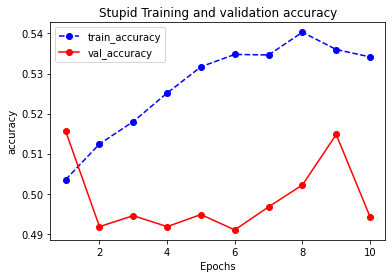

In [ ]:
my_model('Stupid',0,0,0,0,"",10,100,1)

Epoch 1/10
147/147 [==============================] - 58s 288ms/step - loss: 0.6013 - accuracy: 0.6551 - val_loss: 0.5235 - val_accuracy: 0.7475
Epoch 2/10
147/147 [==============================] - 42s 286ms/step - loss: 0.3905 - accuracy: 0.8274 - val_loss: 0.5383 - val_accuracy: 0.7525
Epoch 3/10
147/147 [==============================] - 43s 291ms/step - loss: 0.2965 - accuracy: 0.8758 - val_loss: 0.5620 - val_accuracy: 0.7536
Epoch 4/10
147/147 [==============================] - 42s 283ms/step - loss: 0.2388 - accuracy: 0.9051 - val_loss: 0.5914 - val_accuracy: 0.7399
Epoch 5/10
147/147 [==============================] - 43s 295ms/step - loss: 0.2027 - accuracy: 0.9215 - val_loss: 0.6976 - val_accuracy: 0.7448
Epoch 6/10
147/147 [==============================] - 42s 287ms/step - loss: 0.1669 - accuracy: 0.9352 - val_loss: 0.8453 - val_accuracy: 0.7344
Epoch 7/10
147/147 [==============================] - 42s 287ms/step - loss: 0.1494 - accuracy: 0.9402 - val_loss: 0.8713 - val_ac

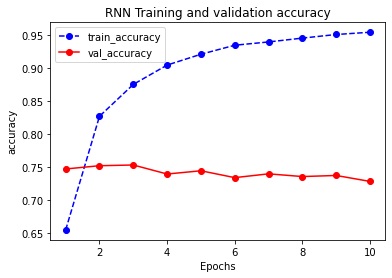

In [ ]:
my_model('RNN',32,64,32,16,"",10,100,1)

Epoch 1/10
147/147 [==============================] - 5s 33ms/step - loss: 0.6569 - accuracy: 0.6013 - val_loss: 0.5428 - val_accuracy: 0.7275
Epoch 2/10
147/147 [==============================] - 5s 32ms/step - loss: 0.4707 - accuracy: 0.7826 - val_loss: 0.5014 - val_accuracy: 0.7519
Epoch 3/10
147/147 [==============================] - 5s 33ms/step - loss: 0.3626 - accuracy: 0.8460 - val_loss: 0.5232 - val_accuracy: 0.7558
Epoch 4/10
147/147 [==============================] - 5s 32ms/step - loss: 0.2928 - accuracy: 0.8783 - val_loss: 0.5663 - val_accuracy: 0.7508
Epoch 5/10
147/147 [==============================] - 5s 33ms/step - loss: 0.2400 - accuracy: 0.9031 - val_loss: 0.6045 - val_accuracy: 0.7475
Epoch 6/10
147/147 [==============================] - 5s 32ms/step - loss: 0.1986 - accuracy: 0.9216 - val_loss: 0.6644 - val_accuracy: 0.7404
Epoch 7/10
147/147 [==============================] - 5s 32ms/step - loss: 0.1706 - accuracy: 0.9321 - val_loss: 0.7154 - val_accuracy: 0.7434

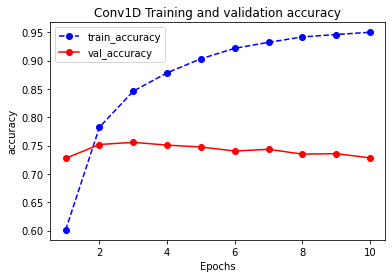

In [ ]:
my_model('Conv1D',64,64,3,32,"",10,100,1)

In [ ]:
# impact of N on the accuracy
res_acc, res_n,res_ep=[[],[],[]]
for n in range(2,int(max_words),2):
  a,ep=my_model('Conv1D',64,64,3,32,"",10,100,0)
  print(n)
  res_acc.append(a)
  res_n.append(n)
  res_ep.append(ep)

Epoch 1/10
147/147 [==============================] - 31s 14ms/step - loss: 0.6498 - accuracy: 0.6119 - val_loss: 0.5290 - val_accuracy: 0.7352
Epoch 2/10
147/147 [==============================] - 2s 12ms/step - loss: 0.4451 - accuracy: 0.7944 - val_loss: 0.4949 - val_accuracy: 0.7560
Epoch 3/10
147/147 [==============================] - 2s 12ms/step - loss: 0.3188 - accuracy: 0.8670 - val_loss: 0.5341 - val_accuracy: 0.7612
Epoch 4/10
147/147 [==============================] - 2s 12ms/step - loss: 0.2290 - accuracy: 0.9107 - val_loss: 0.5984 - val_accuracy: 0.7522
Epoch 5/10
147/147 [==============================] - 2s 12ms/step - loss: 0.1701 - accuracy: 0.9350 - val_loss: 0.6864 - val_accuracy: 0.7448
Epoch 6/10
147/147 [==============================] - 2s 12ms/step - loss: 0.1273 - accuracy: 0.9520 - val_loss: 0.7532 - val_accuracy: 0.7429
Epoch 7/10
147/147 [==============================] - 2s 12ms/step - loss: 0.1012 - accuracy: 0.9605 - val_loss: 0.8632 - val_accuracy: 0.738

Text(0, 0.5, 'Accuracy')

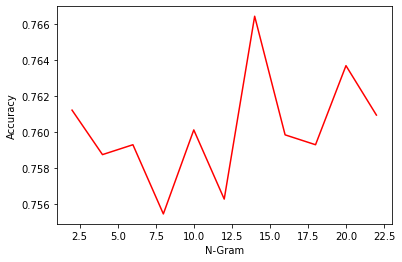

In [ ]:
res_acc=np.array(res_acc)
res_n=np.array(res_n)
res_ep=np.array(res_ep)
plt.plot(res_n,res_acc,'r-')
#plt.plot(res_n,res_ep,'b-')
plt.xlabel('N-Gram')
plt.ylabel('Accuracy')

Epoch 1/10
147/147 [==============================] - 4s 17ms/step - loss: 0.6172 - accuracy: 0.6459 - val_loss: 0.4962 - val_accuracy: 0.7631
Epoch 2/10
147/147 [==============================] - 2s 15ms/step - loss: 0.4113 - accuracy: 0.8154 - val_loss: 0.4883 - val_accuracy: 0.7653
Epoch 3/10
147/147 [==============================] - 2s 15ms/step - loss: 0.2949 - accuracy: 0.8775 - val_loss: 0.5312 - val_accuracy: 0.7618
Epoch 4/10
147/147 [==============================] - 2s 15ms/step - loss: 0.2069 - accuracy: 0.9154 - val_loss: 0.6191 - val_accuracy: 0.7558
Epoch 5/10
147/147 [==============================] - 2s 15ms/step - loss: 0.1493 - accuracy: 0.9405 - val_loss: 0.7366 - val_accuracy: 0.7497
Epoch 6/10
147/147 [==============================] - 2s 15ms/step - loss: 0.1111 - accuracy: 0.9561 - val_loss: 0.8272 - val_accuracy: 0.7404
Epoch 7/10
147/147 [==============================] - 2s 15ms/step - loss: 0.0915 - accuracy: 0.9621 - val_loss: 0.9245 - val_accuracy: 0.7330

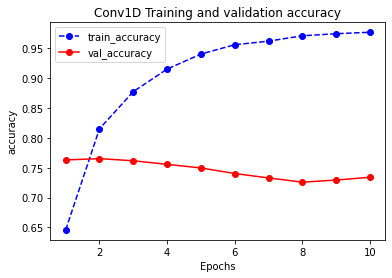

In [ ]:
my_model('Conv1D',64,64,[2,4,14],32,"",10,100,1)

# III.2 Use Chinese word vector

In [ ]:
X_train,Y_train,X_test,Y_test,max_words=vec_select(2)
# prepare embedding matrix from cn_model for keras
# since the embedding is already trained, we can use a much bigger matrix to improve the over-fitting problem that we have in version 1
top_words=50000
embedding_dims=300
embedding_matrix = np.zeros((top_words, embedding_dims))

for i in range(top_words):
    embedding_matrix[i,:] =cn_model[cn_model.index2word[i]][:embedding_dims]
embedding_matrix = embedding_matrix.astype('float32')

# prepare vectorized data
X_train = pad_sequences(X_train, maxlen=max_words,padding='pre',truncating='pre')
X_test = pad_sequences(X_test, maxlen=max_words,padding='pre',truncating='pre')
# using 0 t oreplace words that exceeds top_word
X_train[ X_train>=top_words ] = 0
X_test[ X_test>=top_words ] = 0
#convert dataset to numpy()
Y_train=np.array(Y_train)
Y_test=np.array(Y_test)

Epoch 1/10
170/170 [==============================] - 178s 727ms/step - loss: 0.5943 - accuracy: 0.6719 - val_loss: 0.5291 - val_accuracy: 0.7397
Epoch 2/10
170/170 [==============================] - 126s 740ms/step - loss: 0.4820 - accuracy: 0.7675 - val_loss: 0.4909 - val_accuracy: 0.7630
Epoch 3/10
170/170 [==============================] - 124s 730ms/step - loss: 0.4414 - accuracy: 0.7900 - val_loss: 0.4658 - val_accuracy: 0.7764
Epoch 4/10
170/170 [==============================] - 123s 724ms/step - loss: 0.4101 - accuracy: 0.8073 - val_loss: 0.4781 - val_accuracy: 0.7743
Epoch 5/10
170/170 [==============================] - 126s 740ms/step - loss: 0.3750 - accuracy: 0.8236 - val_loss: 0.4731 - val_accuracy: 0.7790
Epoch 6/10
170/170 [==============================] - 125s 736ms/step - loss: 0.3438 - accuracy: 0.8448 - val_loss: 0.4605 - val_accuracy: 0.7812
Epoch 7/10
170/170 [==============================] - 124s 730ms/step - loss: 0.3053 - accuracy: 0.8649 - val_loss: 0.4793 -

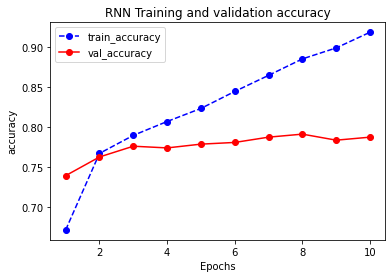

In [ ]:
my_model('RNN',300,32,16,32,embedding_matrix,10,100,1)

Epoch 1/10
170/170 [==============================] - 58s 334ms/step - loss: 0.5959 - accuracy: 0.6569 - val_loss: 0.4875 - val_accuracy: 0.7614
Epoch 2/10
170/170 [==============================] - 56s 330ms/step - loss: 0.4004 - accuracy: 0.8202 - val_loss: 0.4681 - val_accuracy: 0.7788
Epoch 3/10
170/170 [==============================] - 56s 329ms/step - loss: 0.2739 - accuracy: 0.8873 - val_loss: 0.4898 - val_accuracy: 0.7845
Epoch 4/10
170/170 [==============================] - 56s 329ms/step - loss: 0.1713 - accuracy: 0.9345 - val_loss: 0.5915 - val_accuracy: 0.7767
Epoch 5/10
170/170 [==============================] - 56s 331ms/step - loss: 0.1129 - accuracy: 0.9555 - val_loss: 0.6878 - val_accuracy: 0.7748
Epoch 6/10
170/170 [==============================] - 56s 330ms/step - loss: 0.0735 - accuracy: 0.9704 - val_loss: 0.7989 - val_accuracy: 0.7701
Epoch 7/10
170/170 [==============================] - 56s 330ms/step - loss: 0.0624 - accuracy: 0.9741 - val_loss: 0.8516 - val_ac

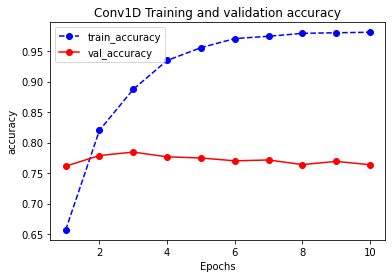

In [ ]:
my_model('Conv1D',300,32,5,64,"",10,100,1)

In [ ]:
# impact of N on the accuracy
res_acc, res_n,res_ep=[[],[],[]]
for n in range(2,int(max_words/2),3):
  a,ep=my_model('Conv1D',300,32,n,64,"",10,100,0)
  print(n)
  res_acc.append(a)
  res_n.append(n)
  res_ep.append(ep)



Epoch 1/10
170/170 [==============================] - 58s 165ms/step - loss: 0.5791 - accuracy: 0.6860 - val_loss: 0.4789 - val_accuracy: 0.7706
Epoch 2/10
170/170 [==============================] - 27s 158ms/step - loss: 0.3886 - accuracy: 0.8274 - val_loss: 0.4615 - val_accuracy: 0.7835
Epoch 3/10
170/170 [==============================] - 27s 159ms/step - loss: 0.2584 - accuracy: 0.8959 - val_loss: 0.5029 - val_accuracy: 0.7861
Epoch 4/10
170/170 [==============================] - 27s 157ms/step - loss: 0.1607 - accuracy: 0.9400 - val_loss: 0.5672 - val_accuracy: 0.7802
Epoch 5/10
170/170 [==============================] - 27s 157ms/step - loss: 0.1030 - accuracy: 0.9615 - val_loss: 0.6500 - val_accuracy: 0.7837
Epoch 6/10
170/170 [==============================] - 27s 158ms/step - loss: 0.0687 - accuracy: 0.9746 - val_loss: 0.7337 - val_accuracy: 0.7722
Epoch 7/10
170/170 [==============================] - 27s 158ms/step - loss: 0.0508 - accuracy: 0.9792 - val_loss: 0.8004 - val_ac

Text(0, 0.5, 'Accurac')

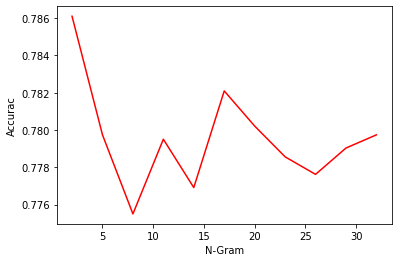

In [ ]:
res_acc=np.array(res_acc)
res_n=np.array(res_n)
res_ep=np.array(res_ep)
plt.plot(res_n,res_acc,'r-')
#plt.plot(res_n,res_ep,'b-')
plt.xlabel('N-Gram')
plt.ylabel('Accuracy')



Epoch 1/10
170/170 [==============================] - 32s 177ms/step - loss: 0.5807 - accuracy: 0.6735 - val_loss: 0.4658 - val_accuracy: 0.7788
Epoch 2/10
170/170 [==============================] - 29s 170ms/step - loss: 0.3643 - accuracy: 0.8407 - val_loss: 0.4614 - val_accuracy: 0.7866
Epoch 3/10
170/170 [==============================] - 29s 171ms/step - loss: 0.2119 - accuracy: 0.9169 - val_loss: 0.5198 - val_accuracy: 0.7863
Epoch 4/10
170/170 [==============================] - 29s 169ms/step - loss: 0.1157 - accuracy: 0.9562 - val_loss: 0.6397 - val_accuracy: 0.7762
Epoch 5/10
170/170 [==============================] - 29s 170ms/step - loss: 0.0714 - accuracy: 0.9731 - val_loss: 0.7032 - val_accuracy: 0.7762
Epoch 6/10
170/170 [==============================] - 29s 171ms/step - loss: 0.0494 - accuracy: 0.9798 - val_loss: 0.8129 - val_accuracy: 0.7760
Epoch 7/10
170/170 [==============================] - 29s 169ms/step - loss: 0.0376 - accuracy: 0.9845 - val_loss: 0.8779 - val_ac

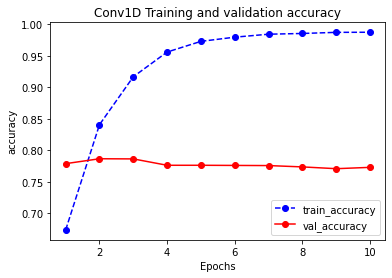

In [ ]:
my_model('Conv1D',300,32,[2,3,16],64,"",10,100,1)

**Results and Conclusion**
1.   RNN has the best accuracy but takes the longest time. CNN has the second best result but saves much more time. 
2.   In such large dataset, it is easy to over fit, we can use droupout to do L1, L2 regularization. 
3.   How to Vectorize? Because Chinese word vector pre-trained the vectorization, so it sets the embedding layer as non-training, therefore expand the dimention of CNN model, increase the accuracy. And this model is less likely to be overfit. 
4.   In general Chinese segementation is much harder than english segmentation due to 

>a. Chinese does not have the blank

>b. The granuality of the Chinese matters. For example: 

          1. 南京市长江大桥欢迎您 

          2. 南京/市长/江大桥/欢迎/您
            City Nanjing's governor Mr.Jiang Welcomes you
          3. 南京市/长江/大桥/欢迎/您
             City Nanjing's Changjiang Bridge Welcomes you

>c. Trending new words/slang can also influence the accuracy 

           1. some new words/slang: 因吹丝挺、城会玩、厉害了word哥、emmmmm、扎心了老铁
           2. some sound similiar word: 碉堡
           3. special words: 寡姐、美队、荷兰弟

localized tokenizer will filter out these words for regarding them as stopwords; chinese word vectors will filter out these words because it does not have these words in its dict. 
5.  Next step: add some special keywords that mentioned above to the jieba dictionary. ( jieba.load_userdict(file_name))